# 日々の軌道高度データを作成する

毎日0:00UT時点での軌道要素データ(軌道長半径・近点・遠点)を線形補間で作成する。0:00UT時点での実際の衛星の位置ではない。

複数の EPOCH の時間間隔が1秒以下の時には、CREATION_DATE が新しいもの1つを残して、他は削除してから、補間を行う。
(必ずしも最後のEPOCHが残るわけではない)

In [1]:
import pandas as pd
import numpy as np
import os
import math
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# 衛星番号
# Hinode
norad_cat_id = 29479
# Daichi (ALOS)
#norad_cat_id = 28931
# Shizuku (GCOM-W1)
#norad_cat_id = 38337

In [4]:
# 対象期間
if norad_cat_id != 38337:
    date_start = datetime(2011, 1, 1, 0, 0)
else:
    date_start = datetime(2012, 7, 1, 0, 0)
date_end   = datetime(2020, 1, 1, 0, 0)

In [5]:
# 各columnの型
# https://www.space-track.org/basicspacedata/modeldef/class/gp/format/html も参照のこと
# decimal型のcolumnはfloat64として取り扱うことにする
# 実際の元データでnullとなっているものがあるのは COUNTRY_CODE, DECAY_DATE, LAUNCH_DATE, OBJECT_ID, RCS_SIZE, SITE
# 型として str を指定すると、元データが null のとき、"None" という文字列になってしまうので、object を指定する
dtype = {'CCSDS_OMM_VERS': object,  'COMMENT': object,  'CREATION_DATE': 'datetime64[ns]',  'ORIGINATOR': object, 
       'OBJECT_NAME': object,  'OBJECT_ID': object,  'CENTER_NAME': object,  'REF_FRAME': object, 
       'TIME_SYSTEM': object,  'MEAN_ELEMENT_THEORY': object,  'EPOCH': 'datetime64[ns]',  'MEAN_MOTION': 'float64', 
       'ECCENTRICITY': 'float64',  'INCLINATION': 'float64',  'RA_OF_ASC_NODE': 'float64', 
       'ARG_OF_PERICENTER': 'float64',  'MEAN_ANOMALY': 'float64',  'EPHEMERIS_TYPE': 'int8', 
       'CLASSIFICATION_TYPE': object,  'NORAD_CAT_ID': 'uint32',  'ELEMENT_SET_NO': 'uint16', 
       'REV_AT_EPOCH': 'uint32',  'BSTAR': 'float64',  'MEAN_MOTION_DOT': 'float64',  'MEAN_MOTION_DDOT': 'float64', 
       'SEMIMAJOR_AXIS': 'float64',  'PERIOD': 'float64',  'APOAPSIS': 'float64',  'PERIAPSIS': 'float64',  'OBJECT_TYPE': object, 
       'RCS_SIZE': object,  'COUNTRY_CODE': object,  'LAUNCH_DATE': 'datetime64[ns]',  'SITE': object,  'DECAY_DATE': 'datetime64[ns]', 
       'FILE': 'uint64',  'GP_ID': 'uint32',  'TLE_LINE0': object,  'TLE_LINE1': object,  'TLE_LINE2': object}

# 以下のcolumnは日時として解釈する (元データが空欄の場合は NaT になる)
convert_dates = ['EPOCH', 'CREATION_DATE', 'LAUNCH_DATE', 'DECAY_DATE']

In [6]:
# gp APIを用いて軌道データをJSON形式でダウンロード (既にダウンロード済みの場合はそれを使う)
file = 'download/gp_history_{}_all.json'.format(norad_cat_id)
if not os.path.isfile(file):
    print('Downloading new data')
    from spacetrack import SpaceTrackClient
    import spacetrack.operators as op
    import spacetrackaccount
    st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)
    data = st.gp_history(norad_cat_id=norad_cat_id, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data, convert_dates = convert_dates, dtype = dtype, precise_float = True)
else:
    print('Using pre-existing data')
    df = pd.read_json(file, convert_dates = convert_dates, dtype = dtype, precise_float = True)
    
print(len(df), 'records')

Using pre-existing data
8522 records


In [7]:
df.rename(columns={'SEMIMAJOR_AXIS': 'SEMIMAJOR_AXIS_ORG', 'APOAPSIS': 'APOAPSIS_ORG', 'PERIAPSIS': 'PERIAPSIS_ORG'}, inplace=True)

In [8]:
# 軌道長半径・近地点高度・遠地点高度 (gp APIの提供する値の精度は 0.001km なので、自分で計算する必要がある)
df['SEMIMAJOR_AXIS'] = (398600.4418 / (df['MEAN_MOTION'] * 2 * math.pi / (24 * 3600)) ** 2) ** (1/3)
df['APOAPSIS'] = (df['SEMIMAJOR_AXIS'] * (1 + df['ECCENTRICITY']))- 6378.135
df['PERIAPSIS'] = (df['SEMIMAJOR_AXIS'] * (1 - df['ECCENTRICITY']))- 6378.135

In [9]:
# EPOCH と CREATION_DATE でソートする
df = df.sort_values(['EPOCH', 'CREATION_DATE']).reset_index(drop=True)

In [10]:
# 対象期間内のみ切り出す(後で補間する際に補外を避けるため2日間のバッファ付き)
buffer = timedelta(days = 2)
dftmp = df[(df['EPOCH'] >= date_start - buffer) & (df['EPOCH'] <= date_end + buffer)]

In [11]:
# バッファ内にデータが含まれているか確認しておく
if not ((dftmp[0:1]['EPOCH'] <= date_start).values & (dftmp[-1:]['EPOCH'] >= date_end).values):
    raise Exception("Error: no data in buffer!")

In [12]:
df = dftmp

In [13]:
# 軌道長半径、近地点、遠地点の時間変化をプロットするための関数
def plot4(df, index):
    fig = plt.figure(figsize=(10, 12))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(index, df['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Semimajor Axis [km]")
    ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(index, df['PERIAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Perigee [km]")
    ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(index, df['APOAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Apogee [km]")
    ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [14]:
# 軌道長半径、近地点、遠地点の日変化をプロット
def plotdot(df, set_ylim = False):
    fig = plt.figure(figsize=(10, 12))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(df['DOT_SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Change of Semimajor Axis [km / day]")
    ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    if set_ylim:  ax1.set_ylim(myrange(df_daily['DOT_SEMIMAJOR_AXIS']))
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(df['DOT_PERIAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Change of Perigee [km / day]")
    ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    if set_ylim: ax2.set_ylim(myrange(df_daily['DOT_PERIAPSIS']))
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(df['DOT_APOAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Change of Apogee [km / day]")
    ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    if set_ylim: ax3.set_ylim(myrange(df_daily['DOT_APOAPSIS']))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [15]:
def myrange(data, percentile = 0.1, expand = 10):
    r = np.nanpercentile(data, [percentile, 100-percentile])
    r[0] = max(r[0], min(data))
    r[1] = min(r[1], max(data))
    w = (r[1] - r[0]) * expand / 100
    r += [-w, +w]
    return r

## 近接しすぎているデータを削除

In [16]:
# EPOCH と CREATION_DATE でソートする (既にされているはずだが念のため)
df = df.sort_values(['EPOCH', 'CREATION_DATE']).reset_index(drop=True)
print(len(df))

5033


In [17]:
# 隣接するデータ間でEPOCH の間隔が1秒以下のデータの個数を確認
dt = -df['EPOCH'].diff(-1) / pd.Timedelta(seconds = 1)
dt2 = df['EPOCH'].diff(1) / pd.Timedelta(seconds = 1)
flag = (dt <= 1) | (dt2 <= 1)
print(flag.sum(), 'records')
#df[['EPOCH', 'CREATION_DATE']][flag].head(15)

82 records


In [18]:
# EPOCH間隔が1秒以上離れているデータごとにグループIDを振る (グループIDはグループの最初のインデックス値)
df['group'] = 0
nlargegroups = 0
currentgroupid = None
first_record_in_group = None
delta = pd.Timedelta(seconds = 1)
for index in df.index:
    if index == 0 or (df.at[index, 'EPOCH'] - df.at[index - 1, 'EPOCH']) > delta:
        currentgroupid = index
        first_record_in_group = True
    else:
        if first_record_in_group:
            first_record_in_group = False
            currentgroupid = index - 1
            nlargegroups += 1

    df.at[index, 'group'] = currentgroupid
print(nlargegroups, 'groups')

41 groups


In [19]:
# 削除するべきデータ数を確認
print(flag.sum() - nlargegroups, 'records will be deleted')

41 records will be deleted


In [20]:
# グループごとにCREATION_DATE が新しいもの1つを残して、他は削除する。
df_out = df.sort_values(['group', 'CREATION_DATE']).drop_duplicates(subset='group', keep='last').sort_values(['EPOCH', 'CREATION_DATE']).drop('group', axis=1)
print(len(df_out), 'records')

4992 records


## 1日間隔のデータを作成

In [21]:
# 出力されるデータのindex
epoch_daily = pd.date_range(date_start, date_end, freq='D')
df_daily = pd.DataFrame(index = epoch_daily)
df_daily.index.name = 'DATE'

In [22]:
# datetime64 をfloat(ユリウス日)に変換
time_in = [x.to_julian_date() for x in df_out['EPOCH']]
time_out = [x.to_julian_date() for x in epoch_daily]

In [23]:
df_daily['SEMIMAJOR_AXIS'] = np.interp(time_out, time_in, df_out['SEMIMAJOR_AXIS'])
df_daily['PERIAPSIS'] = np.interp(time_out, time_in, df_out['PERIAPSIS'])
df_daily['APOAPSIS'] = np.interp(time_out, time_in, df_out['APOAPSIS'])
df_daily['SEMIMAJOR_AXIS_ORG'] = np.interp(time_out, time_in, df_out['SEMIMAJOR_AXIS_ORG'])
df_daily['PERIAPSIS_ORG'] = np.interp(time_out, time_in, df_out['PERIAPSIS_ORG'])
df_daily['APOAPSIS_ORG'] = np.interp(time_out, time_in, df_out['APOAPSIS_ORG'])

In [24]:
df_daily['DOT_SEMIMAJOR_AXIS'] = df_daily['SEMIMAJOR_AXIS'].diff()
df_daily['DOT_PERIAPSIS'] = df_daily['PERIAPSIS'].diff()
df_daily['DOT_APOAPSIS'] = df_daily['APOAPSIS'].diff()
df_daily['DOT_SEMIMAJOR_AXIS_ORG'] = df_daily['SEMIMAJOR_AXIS_ORG'].diff()
df_daily['DOT_PERIAPSIS_ORG'] = df_daily['PERIAPSIS_ORG'].diff()
df_daily['DOT_APOAPSIS_ORG'] = df_daily['APOAPSIS_ORG'].diff()

In [25]:
csvfile = "{}_{}.csv".format((df['NORAD_CAT_ID'])[0], (df['OBJECT_NAME'])[0]).replace(' ', '_')
print(csvfile)
df_daily.to_csv(csvfile)

29479_HINODE_(SOLAR_B).csv


In [26]:
df.head()

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS_ORG,PERIOD,APOAPSIS_ORG,PERIAPSIS_ORG,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,SEMIMAJOR_AXIS,APOAPSIS,PERIAPSIS,group
0,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-12-31 08:23:02,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-12-30 22:10:36.161760,14.630523,0.001649,98.0962,3.6234,71.4261,288.8718,0,U,29479,999,22811,0.000028,9.700000e-07,0.0,7061.476,98.424,694.987,671.696,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1017983,81082411,0 HINODE (SOLAR B),1 29479U 06041A 10364.92402965 +.00000097 +00000-0 +28118-4 0 9993,2 29479 098.0962 003.6234 0016492 071.4261 288.8718 14.63052325228115,7061.472447,694.983228,671.691667,0
1,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-12-31 00:43:19,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-12-31 01:27:34.149023,14.630521,0.001651,98.0961,3.7577,71.0531,289.2453,0,U,29479,999,22813,0.000018,4.400000e-07,0.0,7061.477,98.424,694.999,671.685,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1017874,81075481,0 HINODE (SOLAR B),1 29479U 06041A 10365.06081191 .00000044 00000-0 17796-4 0 9995,2 29479 098.0961 003.7577 0016508 071.0531 289.2453 14.63052146228133,7061.473023,694.995103,671.680944,1
2,2.0,GENERATED VIA SPACE-TRACK.ORG API,2011-01-01 08:28:58,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-12-31 19:30:52.966656,14.630525,0.001651,98.0961,4.4959,68.7213,291.5752,0,U,29479,999,22824,0.000027,9.300000e-07,0.0,7061.476,98.424,695.001,671.680,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1018333,81096656,0 HINODE (SOLAR B),1 29479U 06041A 10365.81311304 +.00000093 +00000-0 +27319-4 0 9996,2 29479 098.0961 004.4959 0016513 068.7213 291.5752 14.63052533228241,7061.471778,694.997386,671.676170,2
3,2.0,GENERATED VIA SPACE-TRACK.ORG API,2011-01-01 00:39:39,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2011-01-01 02:04:48.891935,14.630526,0.001648,98.0960,4.7645,68.1042,292.1916,0,U,29479,999,22828,0.000029,1.040000e-06,0.0,7061.475,98.424,694.978,671.703,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1018292,81090724,0 HINODE (SOLAR B),1 29479U 06041A 11001.08667699 .00000104 00000-0 29373-4 0 9999,2 29479 098.0960 004.7645 0016480 068.1042 292.1916 14.63052637228280,7061.471443,694.973748,671.699138,3
4,2.0,GENERATED VIA SPACE-TRACK.ORG API,2011-01-02 08:06:07,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2011-01-01 18:29:38.669279,14.630532,0.001650,98.0960,5.4354,66.1035,294.1891,0,U,29479,999,22838,0.000044,1.790000e-06,0.0,7061.474,98.424,694.989,671.688,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1018831,81112769,0 HINODE (SOLAR B),1 29479U 06041A 11001.77058645 +.00000179 +00000-0 +43979-4 0 9990,2 29479 098.0960 005.4354 0016499 066.1035 294.1891 14.63053225228384,7061.469551,694.985270,671.683833,4


In [27]:
df_daily.head(5)

,SEMIMAJOR_AXIS,PERIAPSIS,APOAPSIS,SEMIMAJOR_AXIS_ORG,PERIAPSIS_ORG,APOAPSIS_ORG,DOT_SEMIMAJOR_AXIS,DOT_PERIAPSIS,DOT_APOAPSIS,DOT_SEMIMAJOR_AXIS_ORG,DOT_PERIAPSIS_ORG,DOT_APOAPSIS_ORG
DATE,,,,,,,,,,,,
2011-01-01,7061.471549,671.691861,694.981238,7061.475317,671.695713,694.985287,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,7061.468759,671.691332,694.976186,7061.472994,671.695380,694.979943,-0.002790,-0.000529,-0.005052,-0.002323,-0.000333,-0.005344
2011-01-03,7061.467941,671.721155,694.944726,7061.471702,671.725024,694.948381,-0.000819,0.029823,-0.031460,-0.001291,0.029644,-0.031562
2011-01-04,7061.467406,671.709006,694.955806,7061.471000,671.712776,694.960224,-0.000534,-0.012149,0.011080,-0.000702,-0.012248,0.011843
2011-01-05,7061.466720,671.742451,694.920988,7061.470575,671.746343,694.925382,-0.000686,0.033445,-0.034818,-0.000425,0.033568,-0.034842


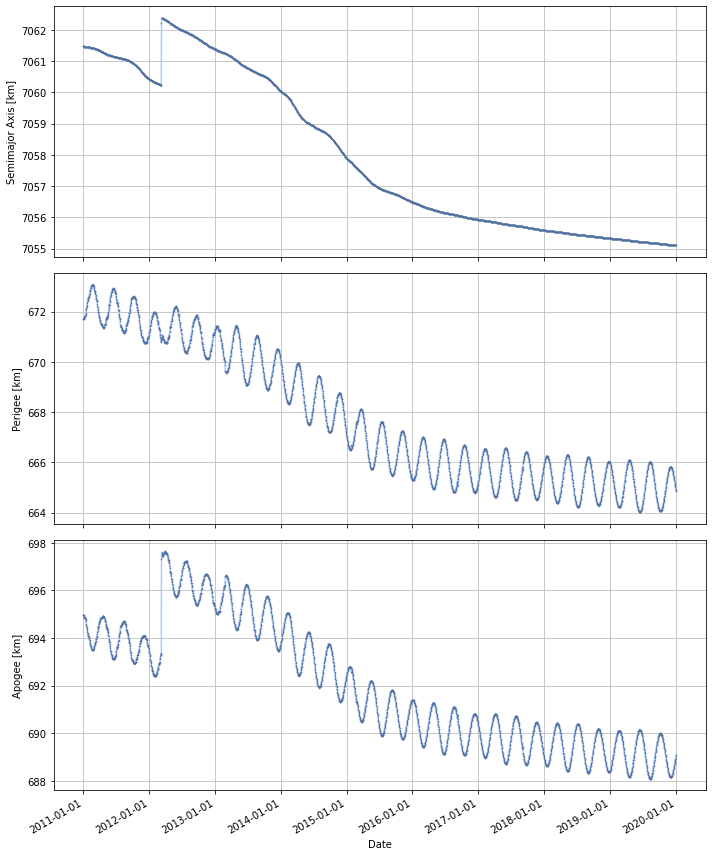

In [28]:
plot4(df_daily, df_daily.index)

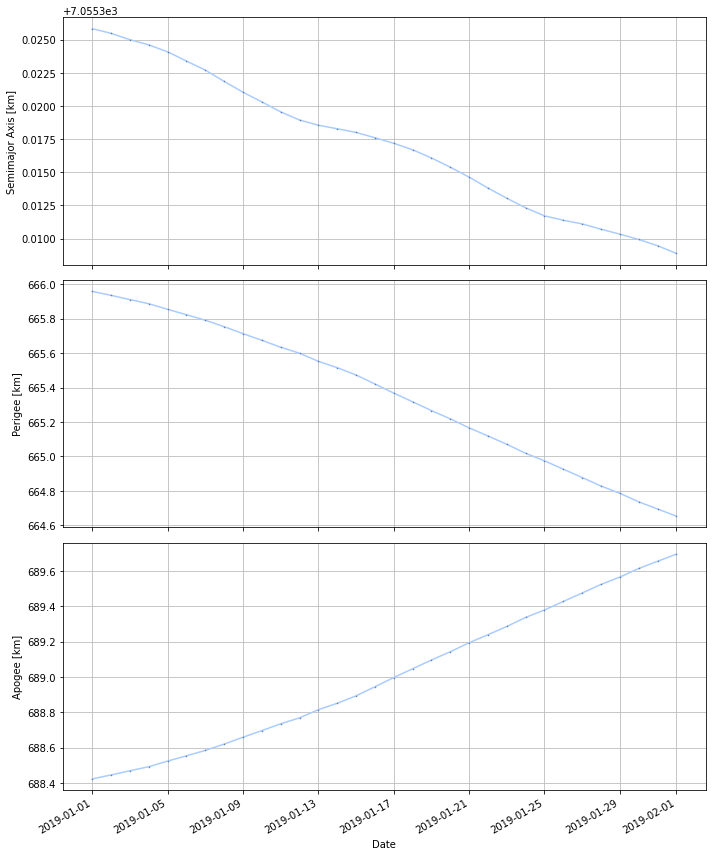

In [29]:
plot4(df_daily['2019-01-01': '2019-02-01'], df_daily['2019-01-01': '2019-02-01'].index)

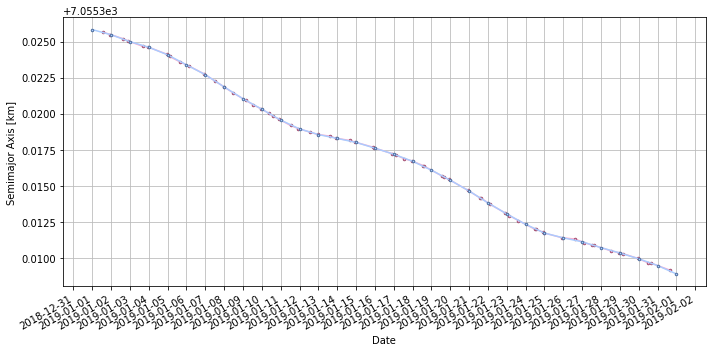

In [30]:
# きちんと補間できている?
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
start='2019-01-01'
end='2019-02-01'
df_out_trim = df_out[(df_out['EPOCH'] >=start) & (df_out['EPOCH'] <= end)]
ax1.plot(df_out_trim['EPOCH'], df_out_trim['SEMIMAJOR_AXIS'], color='#ffaacc', marker='.', markersize=5, markeredgecolor='#a05070')
ax1.plot(df_daily[start:end].index, df_daily[start:end]['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=5, markeredgecolor='#5070a0')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1, tz=None))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
#ax1.set_xlim(datetime(2011, 1, 1), datetime(2011, 1, 15))
#ax1.set_ylim(7061.459, 7061.476)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()    
plt.show()

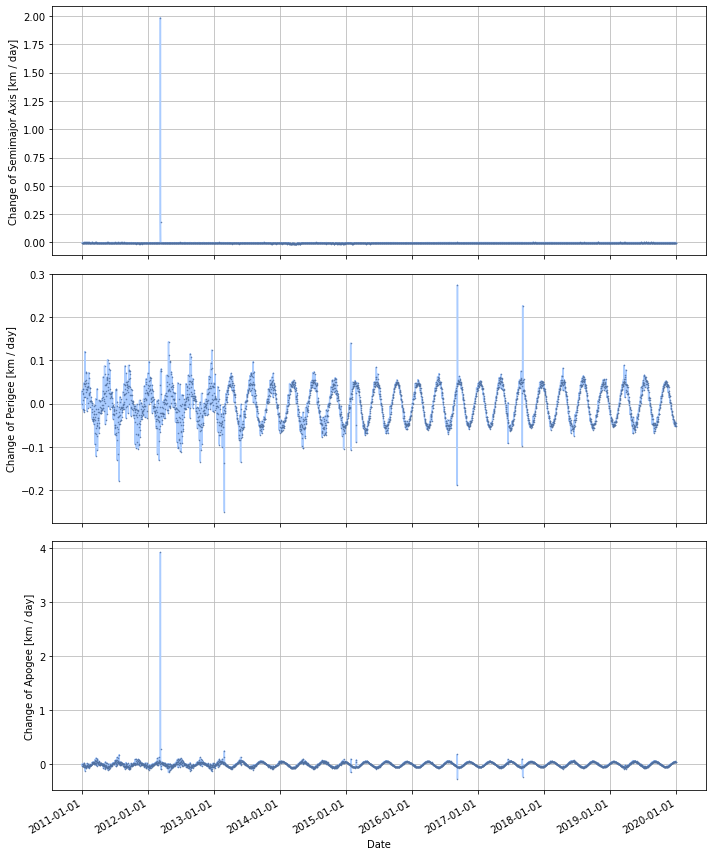

In [31]:
plotdot(df_daily)

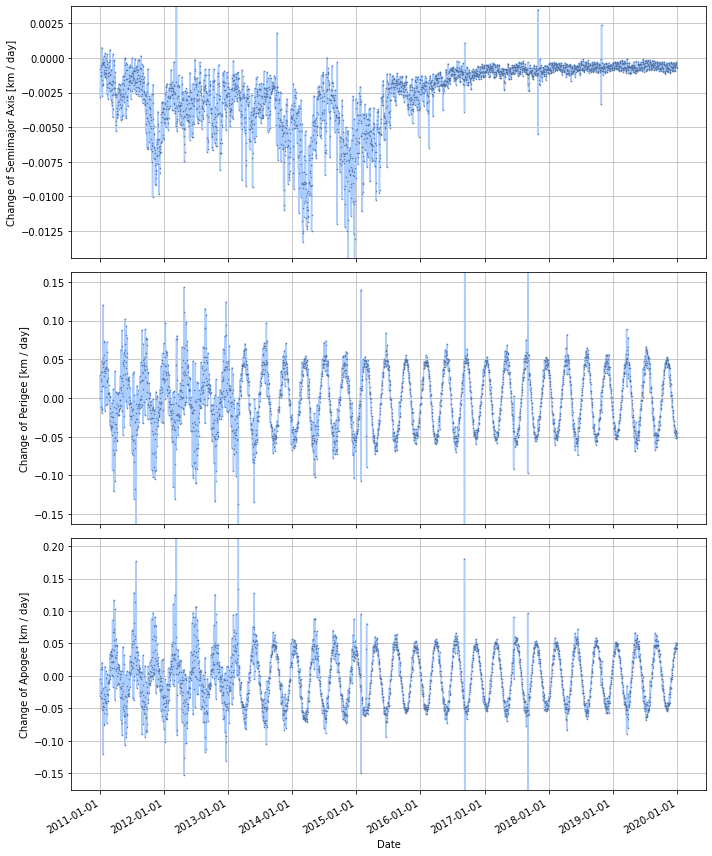

In [32]:
plotdot(df_daily, set_ylim=True)

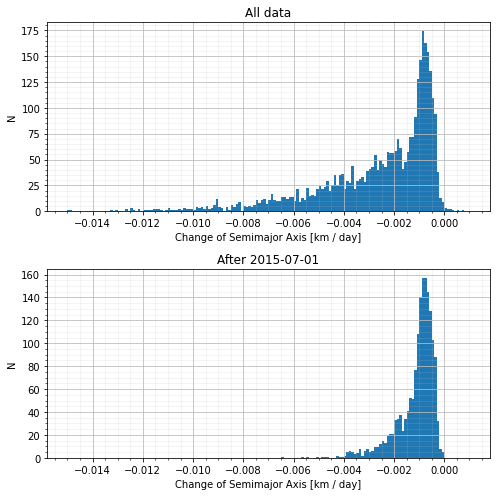

In [33]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(2, 1, 1)
with np.errstate(invalid='ignore'):
    ax1.hist(df_daily['DOT_SEMIMAJOR_AXIS'], bins=160, range = (-0.015,0.001))
ax1.set_title("All data")
ax1.set_xlabel("Change of Semimajor Axis [km / day]")
ax1.set_ylabel("N")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
ax2 = fig.add_subplot(2, 1, 2)
with np.errstate(invalid='ignore'):
    ax2.hist(df_daily['2015-07-01':]['DOT_SEMIMAJOR_AXIS'], bins=160, range = (-0.015,0.001))
ax2.set_title("After 2015-07-01")
ax2.set_xlabel("Change of Semimajor Axis [km / day]")
ax2.set_ylabel("N")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
plt.tight_layout()
plt.show()

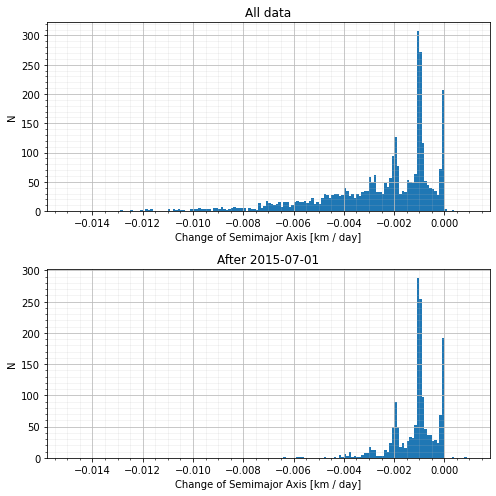

In [34]:
# 参考: gp APIが提供する SEMIMAJOR_AXIS を用いた場合
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(2, 1, 1)
with np.errstate(invalid='ignore'):
    ax1.hist(df_daily['DOT_SEMIMAJOR_AXIS_ORG'], bins=160, range = (-0.015,0.001))
ax1.set_title("All data")
ax1.set_xlabel("Change of Semimajor Axis [km / day]")
ax1.set_ylabel("N")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
ax2 = fig.add_subplot(2, 1, 2)
with np.errstate(invalid='ignore'):
    ax2.hist(df_daily['2015-07-01':]['DOT_SEMIMAJOR_AXIS_ORG'], bins=160, range = (-0.015,0.001))
ax2.set_title("After 2015-07-01")
ax2.set_xlabel("Change of Semimajor Axis [km / day]")
ax2.set_ylabel("N")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
plt.tight_layout()
plt.show()

## CREATION_DATE と EPOCHの時間差

In [35]:
# CREATION_DATE と EPOCH の時間差 (単位: 時間)
df['timelag'] = (df['CREATION_DATE'] - df['EPOCH']) / pd.Timedelta(hours = 1)

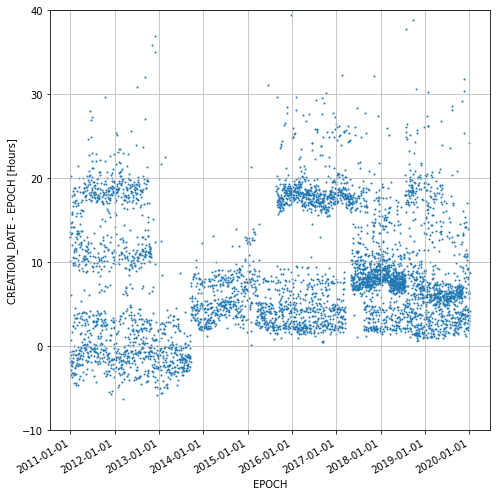

In [36]:
# とりあえず時間差をプロット
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(df['EPOCH'], df['timelag'], s=1)
#ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("EPOCH")
ax1.set_ylabel("CREATION_DATE - EPOCH [Hours]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
#ax1.set_xlim(datetime(2013, 9, 1), datetime(2013, 10, 1))
ax1.set_ylim(-10, 40)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

パターンが時期によって変わっているように見える。2013/9/18 までと 2013/9/19 以降に分割して調べる。

In [37]:
s = datetime(2013, 9, 19)

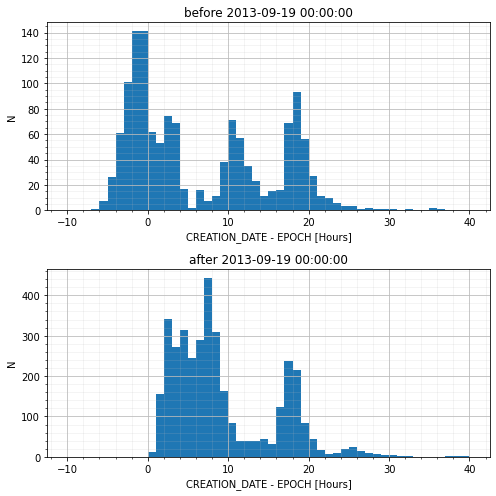

In [38]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(2, 1, 1)
ax1.hist(df[df['EPOCH'] < s]['timelag'], bins=50, range = (-10,40))
ax1.set_title("before {}".format(s))
ax1.set_xlabel("CREATION_DATE - EPOCH [Hours]")
ax1.set_ylabel("N")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
ax2 = fig.add_subplot(2, 1, 2)
ax2.hist(df[df['EPOCH'] >= s]['timelag'], bins=50, range = (-10,40))
ax2.set_title("after {}".format(s))
ax2.set_xlabel("CREATION_DATE - EPOCH [Hours]")
ax2.set_ylabel("N")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
plt.tight_layout()
plt.show()

In [39]:
# CREATION_DATE と EPOCH の時間差でカテゴリ分けしておく
if 'timelag_cat' in df.columns: df.drop(columns=['timelag_cat'], inplace=True)
delta = [-1000, 0, 5, 15, 25, 1000]
delta_names1 = ['A1', 'A2', 'A3', 'A4', 'A5']
df.loc[df['EPOCH'] < s, 'timelag_cat'] = pd.cut(df.loc[df['EPOCH'] < s, 'timelag'], delta, labels = delta_names1)
delta_names2 = ['B1', 'B2', 'B3', 'B4', 'B5']
df.loc[df['EPOCH'] >= s, 'timelag_cat'] = pd.cut(df.loc[df['EPOCH'] >= s, 'timelag'], delta, labels = delta_names2)
df['timelag_cat'] = df['timelag_cat'].astype('category')
df['timelag_cat'].dtypes

CategoricalDtype(categories=['A1', 'A2', 'A3', 'A4', 'A5', 'B2', 'B3', 'B4', 'B5'], ordered=False)

In [40]:
print(df['timelag_cat'].value_counts())

B3    1698
B2    1094
B4     790
A1     478
A4     306
A2     275
A3     271
B5      99
A5      22
Name: timelag_cat, dtype: int64


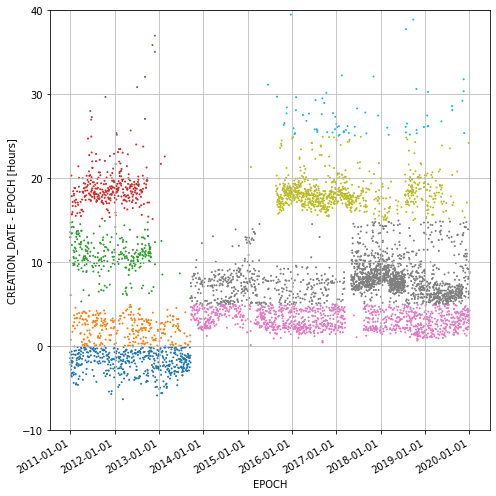

In [41]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(df['EPOCH'], df['timelag'], s=1, c=df['timelag_cat'].cat.codes/10, cmap='tab10')
#ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("EPOCH")
ax1.set_ylabel("CREATION_DATE - EPOCH [Hours]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
#ax1.set_xlim(datetime(2013, 9, 1), datetime(2013, 10, 1))
ax1.set_ylim(-10, 40)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()